# BBC News Classification Kaggle Mini-Project

The objectives of this mini-project are:

- Perform an exploratory data analysis (EDA) procedure.
- Build and train an unsupervised learning model using Non-negative Matrix Factorisation (NMF).
- Build and train a supervised learning model.
- Compare the two models.

## Project setup

Import the required modules and load the datasets.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
from itertools import permutations
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix


In [13]:
data_train = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
data_test = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
sample_solution = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")

### Inspection

#### Training data

In [14]:
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Using the data tab in the competition, we can see that all rows are valid, but only 1440 out 1490 values are unique in the Text column.

In addition, the Category column has a dtype of object without being categorised.

The next cell fixes these two issues.

In [15]:
data_train = data_train.drop_duplicates(subset = ["Text"])
data_train.Category = pd.Categorical(data_train.Category)

Next we check the ratios of the categories using a pie chart. From the chart below, it seems that the categories are well-balanced.

<Axes: >

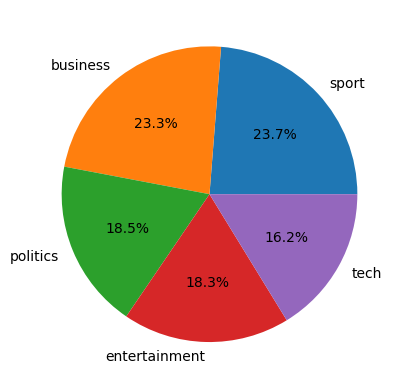

In [16]:
data_train.Category.value_counts().plot.pie(autopct='%1.1f%%', ylabel='')

#### Test data and provided sample solution

These have the same structure as the training data, except that one drops the Category column, while the solution drops the Text column.

In [17]:
print(data_test.info())
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [26]:
print(sample_solution.info())
sample_solution.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


### Preprocessing

The preprocessing tasks under consideration are:

1. Convert to lower case.
1. Remove punctuation.
1. Remove stopwords.
1. Remove common/rare words identified from data exploration.
1. Lemmatisation.
1. Stripping extra white space.
1. 

In [19]:
train_without_numbers = data_train["Text"].str.replace(r'\d+', 'NUM', regex=True)
vectoriser = TfidfVectorizer(stop_words="english")
train_vectorised = vectoriser.fit_transform(train_without_numbers)
print(train_vectorised.shape)

(1440, 23308)


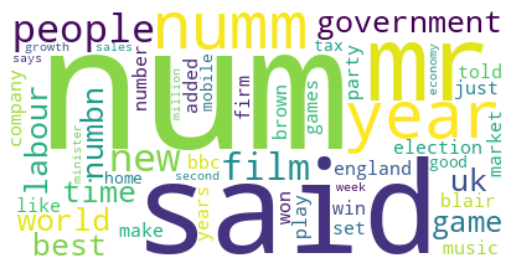

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
word_frequencies = pd.DataFrame(train_vectorised.toarray(), columns=vectoriser.get_feature_names_out()).T.sum(axis=1)
wordcloud = WordCloud(background_color='white', max_words=50).generate_from_frequencies(word_frequencies.to_dict())
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
nmf = NMF(n_components=5)
train_pred = nmf.fit_transform(train_vectorised).argmax(axis=1)

In [22]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels column from dataframe object.
    yp: label prediction output.
    Returns permuted label order and accuracy.
    Example output: ('business', 'politics', 'sport', 'entertainment', 'tech'), 0.74 .
    """
    y_true = ytdf
    best_acc = 0.
    for perm in permutations(ytdf.cat.categories):
        y_pred = [perm[i] for i in yp]
        accuracy = accuracy_score(y_true, y_pred)
        if accuracy > best_acc:
            best_acc = accuracy
            best_perm = perm
    return best_perm, best_acc

labels, acc = label_permute_compare(data_train.Category, train_pred)
print(labels, acc)

('business', 'politics', 'sport', 'entertainment', 'tech') 0.8708333333333333


In [23]:
test_without_numbers = data_test["Text"].str.replace(r'\d+', 'NUM', regex=True)
test_vectorised = vectoriser.transform(test_without_numbers)
test_pred = nmf.transform(test_vectorised).argmax(axis=1)

In [32]:
sample_solution.Category = [labels[x] for x in test_pred]
print(all(sample_solution.ArticleId == data_test.ArticleId))
print(sample_solution)
sample_solution.to_csv("submission.csv", index=False)

True
     ArticleId       Category
0         1018          sport
1         1319           tech
2         1138          sport
3          459       business
4         1020          sport
..         ...            ...
730       1923       business
731        373  entertainment
732       1704           tech
733        206       business
734        471       politics

[735 rows x 2 columns]


## References

1. [How to apply a custom stemmer before passing the training corpus to TfidfVectorizer in sklearn?](https://stackoverflow.com/questions/48925747/how-to-apply-a-custom-stemmer-before-passing-the-training-corpus-to-tfidfvectori)
1. [How does adding/omitting lemmatization affect TF-IDF?](https://stats.stackexchange.com/questions/428967/how-does-adding-omitting-lemmatization-affect-tf-idf)
1. [Comparing Apples to Apple: The Effects of Stemmers on Topic Models](https://mimno.infosci.cornell.edu/papers/schofield_tacl_2016.pdf)
1. [Sklearn: adding lemmatizer to CountVectorizer](https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer)